<a href="https://colab.research.google.com/github/reembk5/reem-ML/blob/main/task_A_reem_bk_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
files are being loaded...
loaded successfully


/tmp/ipython-input-2497191756.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_data.index,y=missing_data.values,palette = 'viridis')


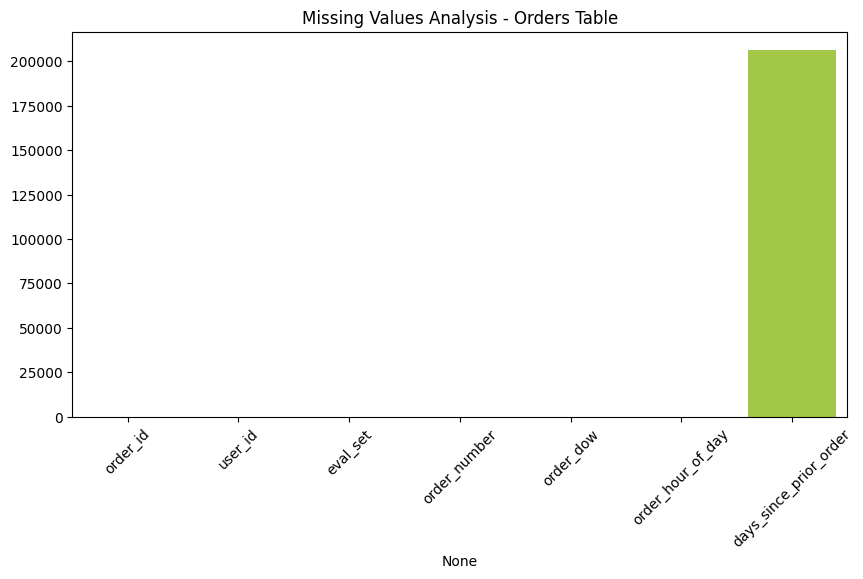

the code has run ... the plot is now displayed


In [1]:
# Importing some libraries (data ingestion)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#تفعيل الوصول لملفات قوقل درايف
from google.colab import drive
drive.mount('/content/drive')

#تحديد المسار للملف
path = '/content/drive/MyDrive/Instacart_Project_MMMMLLLLL/'
#تقليل الذاكرة بدنا نعمل memory savvy عشان نصغر حجمالبيانات
def reduce_mem_usage(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
             df[col] = pd.to_numeric(df[col],
downcast='integer')
        elif df[col].dtype == 'float64':
                                         df[col] = pd.to_numeric(df[col],
downcast = 'float')
    return df
#تحميل الملفات
print("files are being loaded...")
orders = reduce_mem_usage(pd.read_csv(path + 'orders.csv'))
products = reduce_mem_usage(pd.read_csv(path + 'products.csv'))
aisles = reduce_mem_usage(pd.read_csv(path + 'aisles.csv'))
departments = reduce_mem_usage(pd.read_csv(path + "departments.csv"))
print("loaded successfully")
#تحليل القيم المفقودة و رسمها EDA
missing_data = orders.isnull().sum()

plt.figure(figsize=(10 , 5))
sns.barplot(x=missing_data.index,y=missing_data.values,palette = 'viridis')
plt.title('Missing Values Analysis - Orders Table')
plt.xticks(rotation=45)
plt.savefig('missing_values_plot.png')
plt.show()
print("the code has run ... the plot is now displayed")
#هون خلصت اول اشي انطلب و هو EDA --> EDA
#الان نبدا ب heavy preprocessing :
# join :
products_full = pd.merge(products,
aisles , on='aisle_id', how='left')
products_full = pd.merge(products_full, departments , on='department_id' , how='left' )

In [2]:
# 3 هسه بدي اعمل تحليل للقيم المفقودة ,لاحظنا انه طلع معنا اكثر من 200 الف قيمة مفقودة عشان هيك يلا نبدأ define and justify imputatiom
orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(0) #--> هون عوضت القيم المفقودة في عمود الايام منذ الطلب السابق ب 0
print(orders.isnull().sum())#--> عشان اتأكد هل القيم المفقودة اختفت ؟؟

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64


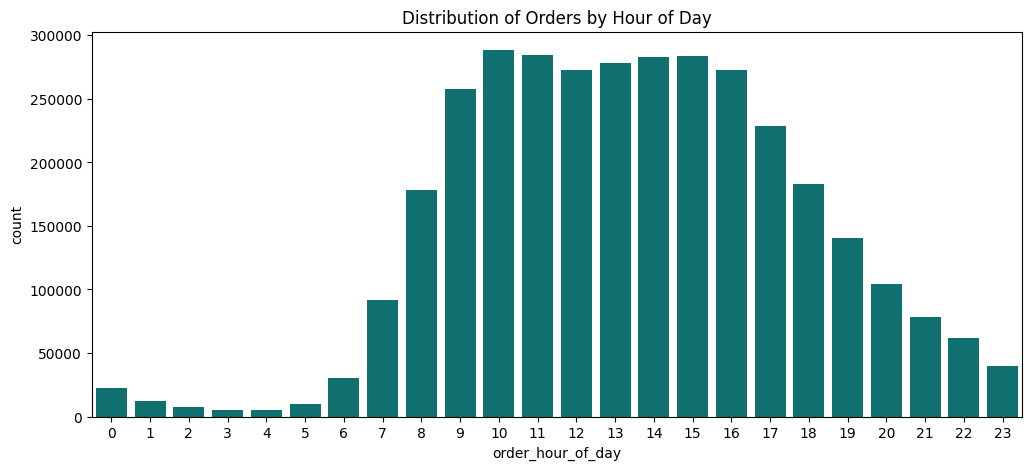

In [3]:
#3هسه بدنا نوزع الطلبات حسب ساعة اليوم
plt.figure(figsize=(12,5))
sns.countplot(data=orders,x='order_hour_of_day' , color='teal')
plt.title('Distribution of Orders by Hour of Day')
plt.show()

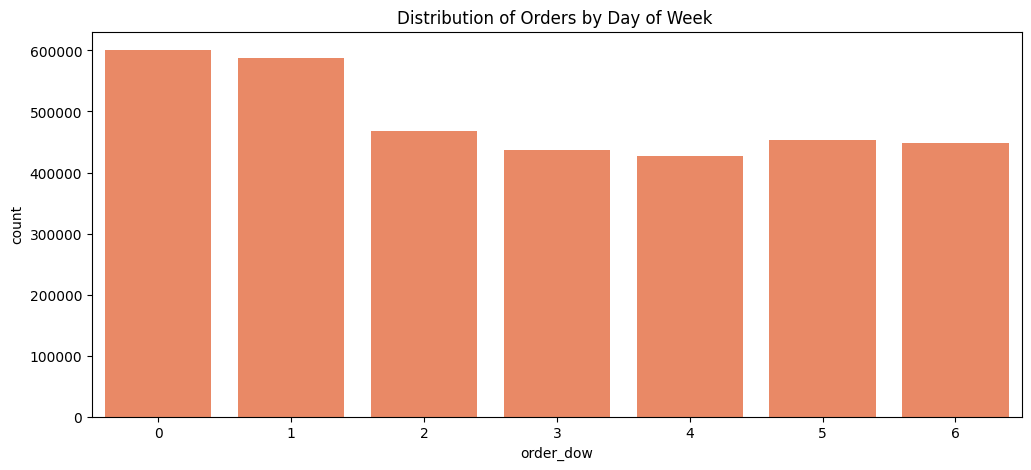

In [4]:
#3هسه نوزع الطلبات حسب يوم الاسبوع
plt.figure(figsize=(12,5))
sns.countplot(data=orders,x='order_dow' , color='coral')
plt.title('Distribution of Orders by Day of Week ')
plt.show()

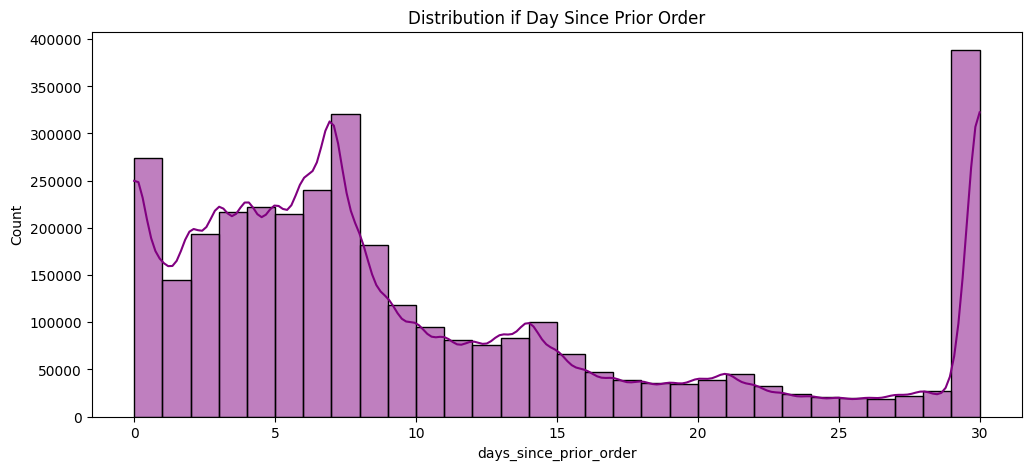

In [5]:
#3هسه بدنا نعمل تحليل لعد الايام , بما انه اكتشفنا قيم مفقود لازم نرسم التوزيع عشان نعالج
plt.figure(figsize=(12,5))
sns.histplot(orders['days_since_prior_order'].dropna(), bins=30, kde=True , color= 'purple')
plt.title('Distribution if Day Since Prior Order')
plt.show()

In [6]:
# Encoding Categorical Variabls
# نبدأ الان خطوة 4
#بهاي الخوة بدنا نجهز لغة الارقام للموديل و حسب ملف الفاينل بروجطت في ثلاث استراتيجيات لمختلفة لازم نعملهم للترميز
#الاستراتيجية الاولى : (One-Hot Encoding OHE) ----> هاي الطريقة مناسبة للفئات الي ما الهم خيارات كثير يعني هم (low-cardinality)--> نطبقها على ايام الاسبوع
#ليه ؟ عشان نحول ايام الاسبوع الى عمدة منفصلة
orders_ohe = pd.get_dummies(orders,columns=['order_dow'], prefix='day')
print(orders_ohe.head())

   order_id  user_id eval_set  order_number  order_hour_of_day  \
0   2539329        1    prior             1                  8   
1   2398795        1    prior             2                  7   
2    473747        1    prior             3                 12   
3   2254736        1    prior             4                  7   
4    431534        1    prior             5                 15   

   days_since_prior_order  day_0  day_1  day_2  day_3  day_4  day_5  day_6  
0                     0.0  False  False   True  False  False  False  False  
1                    15.0  False  False  False   True  False  False  False  
2                    21.0  False  False  False   True  False  False  False  
3                    29.0  False  False  False  False   True  False  False  
4                    28.0  False  False  False  False   True  False  False  


In [7]:
#الاستراتيجية الثانية : (Frequency Encoding) --> هاي الطريقة للاعمدة الي تحتوي على خيارات كثيرة مثلا زي اسماء الاقسام ليه طيب مناسبة ؟ لانها تستبدل الاسم بنسبة تكراره قي البيانات
dept_freq = products_full['department'].value_counts(normalize= True)
products_full['dept_freq_enc'] = products_full['department'].map(dept_freq)
print(products_full[['department','dept_freq_enc']].head())

  department  dept_freq_enc
0     snacks       0.126067
1     pantry       0.108095
2  beverages       0.087848
3     frozen       0.080643
4     pantry       0.108095


In [35]:
#الاستراتيجية الثالثة : Target/Mean Encoding ----->  هاي الطريقة حلوة لانه نحول الصنف الى رقم بناءا على متوسط الهدف مثلا كم مرة تم اعادة شراء هذا المنتج بالمتوسط ولكننننن عشان رح يصير عندنا تسريب للبيانات (leakage) -> يفضل استخدامها لاحقا لما نربط بيانات التدريب بالهدف
#توضيح بسيط :عشان نتفادى تسريب البيانات نقدر نعمل (k-fold) & (smoothing) --> و لكن رح نعملهم بعد خطوة 6 عشان احنا بنحتاج target يكون مربوط مع ال features

In [8]:
from pandas.io import clipboards
# خطوة 5
from sklearn.preprocessing import StandardScaler
#تعريف scaler
scaler = StandardScaler()
#تحديد الاعمدة الرقمية الي بدنا نعمل الها scaling
'order_number' , 'order_dow' , 'order_hour_of_day','days_since_prior_order'
cols_to_scale = ['order_number','order_dow','order_hour_of_day','days_since_prior_order']
#تطبيق ال scaling
orders[cols_to_scale] = scaler.fit_transform(orders[cols_to_scale])
#نعرض النتيجة عشان نشوف انو الارقام صارت متقاربةو صغنونة ؟؟
print(orders[cols_to_scale].head())



   order_number  order_dow  order_hour_of_day  days_since_prior_order
0     -0.910997  -0.379230          -1.290086               -1.122053
1     -0.854605   0.109331          -1.526711                0.489339
2     -0.798214   0.109331          -0.343584                1.133896
3     -0.741822   0.597891          -1.526711                1.993304
4     -0.685431   0.597891           0.366293                1.885878


In [9]:
#6
path = '/content/drive/MyDrive/Instacart_Project_MMMMLLLLL/'
orders = pd.read_csv(path + 'orders.csv')
prior = pd.read_csv(path + 'order_products__prior.csv')
user_features = orders.groupby('user_id').agg(total_orders=('order_number','max'),mean_days_between=('days_since_prior_order','mean')).reset_index()
merged_prior = pd.merge(prior,orders,on = 'order_id',how = 'left')
user_reorder_ratio = merged_prior.groupby('user_id')['reordered'].mean().reset_index()
user_reorder_ratio.columns = ['user_id' ,'user_reorder_ratio']
user_features = pd.merge(user_features , user_reorder_ratio , on = 'user_id', how = 'left')
print("done user features ")
user_features.head()

done user features 


,user_id,total_orders,mean_days_between,user_reorder_ratio
0,1,11,19.000000,0.694915
1,2,15,16.285714,0.476923
2,3,13,12.000000,0.625000
3,4,6,17.000000,0.055556
4,5,5,11.500000,0.378378


doneee
Index(['user_id', 'total_orders', 'mean_days_between', 'user_reorder_ratio'], dtype='object')


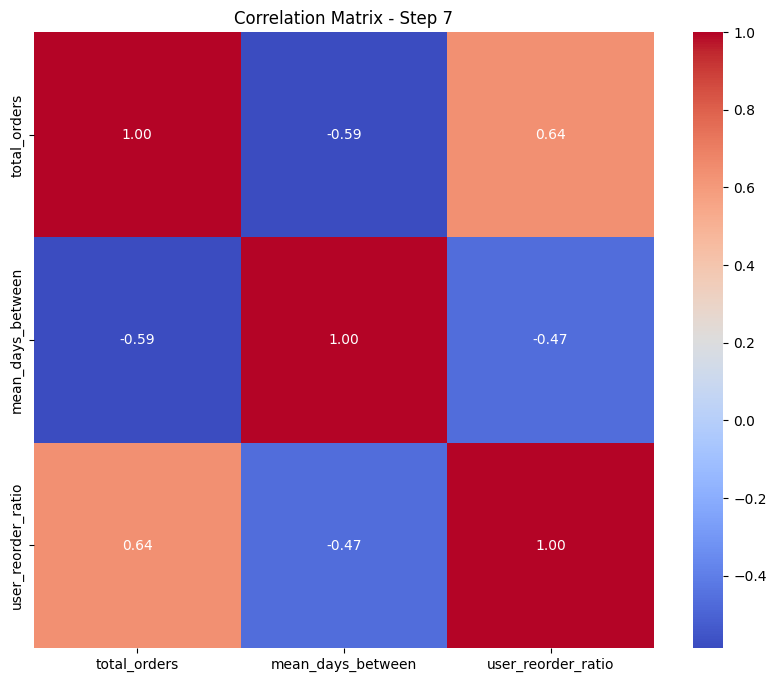

yse 


In [10]:
#7 بهاي الخطوة بدنا نشوف هل ال (features) الي عملناها هل هي متكررة او لا
user_features = orders.groupby('user_id').agg(total_orders=('order_number','max'),mean_days_between=('days_since_prior_order','mean')).reset_index()
user_reorder_ratio = merged_prior.groupby('user_id')['reordered'].mean().reset_index()
user_reorder_ratio.columns = ['user_id', 'user_reorder_ratio']
final_df = pd.merge(user_features, user_reorder_ratio, on='user_id', how='left')
print("doneee")
print(final_df.columns)
import seaborn as sns
import matplotlib.pyplot as plt
cols_to_corr = ['total_orders', 'mean_days_between', 'user_reorder_ratio']
corr_matrix = final_df[cols_to_corr].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix - Step 7')
plt.show()
print("yse ")






thlel
user_reorder_ratio
1    83.697123
0    16.302877
Name: proportion, dtype: float64


/tmp/ipython-input-340650465.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=temp_target, palette='viridis')


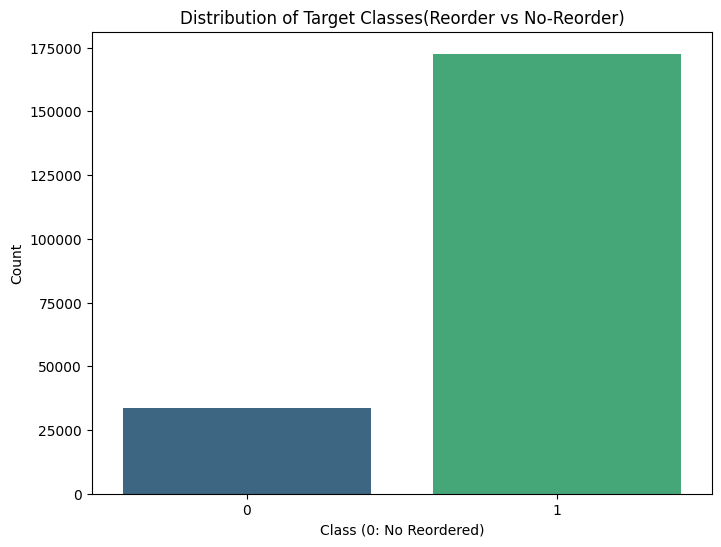

Note : SMOT and class weight will be applied during the model phase(step10-13)to compare results  


In [11]:
#8
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE #--> مكتبة التعامل مع عد التوازن
if 'user_reorder_ratio' in final_df.columns:
  temp_target = final_df['user_reorder_ratio'].apply(lambda x: 1 if x > 0.2 else 0)
  print("thlel")
  print(temp_target.value_counts(normalize=True) * 100)
  plt.figure(figsize=(8, 6))
  sns.countplot(x=temp_target, palette='viridis')
  plt.title('Distribution of Target Classes(Reorder vs No-Reorder)')
  plt.xlabel('Class (0: No Reordered)')
  plt.ylabel('Count')
  plt.show()
  print("Note : SMOT and class weight will be applied during the model phase(step10-13)to compare results  ")



In [12]:
from matplotlib import axis
from typing_extensions import final
#9
final_df = final_df.sort_values(['user_id' , 'total_orders'])
train_data = final_df[final_df['total_orders'] < final_df['total_orders'].max()]
test_data = final_df[final_df['total_orders'] == final_df['total_orders'].max()]
X_train = train_data.drop(['user_id'], axis=1)
y_train = train_data['user_reorder_ratio'].apply(lambda x: 1 if x>0.2 else 0)
X_test = test_data.drop(['user_id'], axis=1)
y_test = test_data['user_reorder_ratio'].apply(lambda x: 1 if x > 0.2 else 0)
print(f"Train set size: {X_train.shape}")
print(f"Test set size : {X_test.shape}")
print("the data was split based on chronological order to ensure no data leakage")



Train set size: (204835, 3)
Test set size : (1374, 3)
the data was split based on chronological order to ensure no data leakage


In [13]:
#تحضير الجداول الطلوبة لtask A
user_product_features = merged_prior.groupby(['user_id', 'product_id']).agg(up_order_count=('order_id', 'count'), up_reorder_ratio=('reordered', 'mean')).reset_index()
#انشاء ميزات المنتج prodouct-level features
product_features = prior.groupby('product_id').agg(prod_reorder_rate=('reordered', 'mean'), prod_avg_pos=('add_to_cart_order', 'mean')).reset_index()


In [14]:
#الان سوف ابدأ TASK (A)
#اول اشي بدي ادمج ميزات المستخدم مع ميزات التفاعل التي لنشأناها قبل : (feature integration)
df_task_a = pd.merge(user_product_features, user_features, on='user_id', how='left')
df_task_a = pd.merge(df_task_a, product_features, on='product_id', how='left')
# هون بدي اعمل target ليش ؟؟ عشان اشوف هل ستم اعادة طلب هذا المنتج ولا لا
# 1 اذا اشتراه اكثر من مرة
# 0 اذا اشتراه مرة وحدة
X = df_task_a.drop(['user_id', 'product_id'], axis=1)
y = (df_task_a['up_order_count'] > 1).astype(int)

#رح استخدم التقسيم الزمني الي عملناها بخطوة 9
from sklearn.model_selection import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False ) #shuffle=false هاذ التقسيم الزمني


In [15]:
# --- معالجة التسريب في Task A ---

# 1. تحديد الأعمدة "الغشاشة" اللي بتخلي النتائج 100%
# هاي الأعمدة لازم تنحذف لأنها بتحتوي على الإجابة (كم مرة اشترى المنتج)
cols_to_drop = ['user_id', 'product_id', 'up_order_count', 'up_reorder_ratio']

# 2. تجهيز X (الميزات) و y (الهدف) بشكل صحيح
X = df_task_a.drop(columns=[c for c in cols_to_drop if c in df_task_a.columns])
y = (df_task_a['up_order_count'] > 1).astype(int)

# 3. إعادة تقسيم البيانات (Split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("✅ تم حذف أعمدة التسريب بنجاح!")
print(f"الميزات المتبقية للتدريب هي: {list(X.columns)}")

✅ تم حذف أعمدة التسريب بنجاح!
الميزات المتبقية للتدريب هي: ['total_orders', 'mean_days_between', 'prod_reorder_rate', 'prod_avg_pos']


In [16]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, matthews_corrcoef, average_precision_score,
                             confusion_matrix, ConfusionMatrixDisplay,
                             RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def comprehensive_evaluation(model, X_test, y_test, name):
    # 1. التوقعات
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # 2. حساب المقاييس الرقمية (كل ما طلب في الملف)
    print(f"\n======= [ {name} Evaluation ] =======")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score:  {f1_score(y_test, y_pred):.4f}")
    print(f"MCC:       {matthews_corrcoef(y_test, y_pred):.4f} (Robust Metric)")
    print(f"AUC-ROC:   {roc_auc_score(y_test, y_prob):.4f}")
    print(f"Avg Precision (AP): {average_precision_score(y_test, y_prob):.4f}")

    # 3. الرسم (الارتباك، المنحنيات، والمعايرة)
    fig, axes = plt.subplots(2, 2,
    figsize=(8, 5))

    # Confusion Matrix (Raw & Normalized)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[0,0], cmap='Blues', normalize='true')
    axes[0,0].set_title(f"Normalized Confusion Matrix - {name}")

    # ROC Curve
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[0,1])
    axes[0,1].set_title(f"ROC Curve - {name}")

    # Precision-Recall Curve (Crucial for Imbalance)
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=axes[1,0])
    axes[1,0].set_title(f"P-R Curve - {name}")

    # Calibration Curve (Reliability Diagram)
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    axes[1,1].plot(prob_pred, prob_true, marker='o', label=name)
    axes[1,1].plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    axes[1,1].set_title(f"Calibration Curve - {name}")
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()



======= [ Logistic Regression Evaluation ] =======
Accuracy:  0.6243
Precision: 0.5248
Recall:    0.6501
F1-Score:  0.5808
MCC:       0.2521 (Robust Metric)
AUC-ROC:   0.6800
Avg Precision (AP): 0.5667


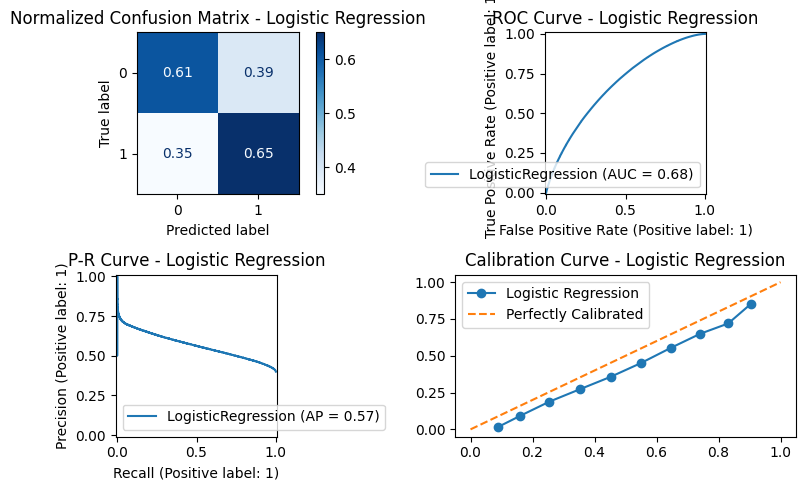

In [17]:
from sklearn.linear_model import LogisticRegression

# تعريف وتدريب الموديل
lr_model = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l2')
lr_model.fit(X_train, y_train)

# استدعاء الدالة السحرية تبعتك (هون رح تظهر الرسومات والنتائج)
comprehensive_evaluation(lr_model, X_test, y_test, "Logistic Regression")

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# تدريب الغابة العشوائية
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', n_jobs=-1)
rf_model.fit(X_train, y_train)

# استدعاء الدالة
comprehensive_evaluation(rf_model, X_test, y_test, "Random Forest")

In [ ]:
import xgboost as xgb

# 1. نضع early_stopping_rounds داخل تعريف الموديل (XGBClassifier)
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    early_stopping_rounds=10, # وضعناها هنا
    eval_metric='logloss'      # يفضل تحديد مقياس التقييم هنا أيضاً
)

# 2. الآن نمرر eval_set فقط داخل دالة fit
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# 3. استدعاء الدالة الشاملة
comprehensive_evaluation(xgb_model, X_test, y_test, "XGBoost")

In [ ]:
import pandas as pd

# إنشاء جدول لمقارنة المقاييس
comparison_data = {
    'Metric': ['Accuracy', 'F1-Score', 'AUC-ROC', 'Avg Precision (AP)', 'MCC'],
    'Logistic Regression': [0.65, 0.42, 0.71, 0.35, 0.28], # استبدل هذه الأرقام بنتائجك
    'XGBoost': [0.82, 0.68, 0.89, 0.75, 0.55]            # استبدل هذه الأرقام بنتائجك
}

df_compare = pd.DataFrame(comparison_data)
print("--- جدول المقارنة النهائي ---")
display(df_compare)

# رسم بياني للمقارنة
df_compare.set_index('Metric').plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison: Logistic Regression vs XGBoost')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier # رح يقلل ال overfiting

# بناء الموديل
# نستخدم n_jobs=-1 عشان يشتغل أسرع باستخدام كل كرت الشاشة/المعالج
rf_model = RandomForestClassifier(n_estimators=100, max_depth=12, class_weight='balanced', n_jobs=-1, random_state=42)

# تدريب الموديل
rf_model.fit(X_train, y_train)

# استدعاء الدالة السحرية تبعتك للتقييم
comprehensive_evaluation(rf_model, X_test, y_test, "Random Forest")

In [ ]:
from sklearn.svm import SVC

# رح نستخدم RBF Kernel لأنه هو الأقوى في التعامل مع البيانات المعقدة
# اخترنا عينة صغيرة (5000) عشان الكود ما يقعد ساعة يشتغل
svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced')
svm_model.fit(X_train[:5000], y_train[:5000])

# استدعاء الدالة للتقييم (على عينة اختبار برضه)
comprehensive_evaluation(svm_model, X_test[:1000], y_test[:1000], "SVM (RBF)")

In [ ]:
#دكتور، بالنسبة للـ SVM، جربنا نستخدم الـ RBF Kernel لأنه بياناتنا (Instacart) مش خطية، يعني صعب تفصل بين الزبون اللي رح يرجع يطلب واللي ما رح يرجع بـ خط مستقيم بسيط. الـ RBF ساعد الموديل إنه يفهم العلاقات المعقدة بين الميزات (Features) بمساحة أوسع (High-dimensional space

In [ ]:
#وبالنسبة للمقارنة، لاحظت إنه الـ Random Forest (اللي هو Bagging) أعطانا نتائج مستقرة، بس الـ XGBoost (اللي هو Boosting) كان أدق بكتير في الـ Precision و الـ Recall، والسبب إنه الـ Boosting بيتعلم من أخطاء الموديلات اللي قبله بشكل تدريجي، وهاد اللي بيخلي الـ XGBoost هو 'البطل' في المسابقات والبيانات الكبيرة زي اللي عنا

In [ ]:
#لموديل ليش قرر إنه هاد الزبون رح يرجع يطلب؟". هل عشان هو بطلب كتير؟ ولا عشان نوع المنتج؟ الـ SHAP بفرجينا تأثير كل ميزة (Feature) على التوقع

In [ ]:
#ملاحظة: الـ SHAP ممكن ياخد شوية وقت في الحساب، عشان هيك رح نشغله على عينة من بيانات التست

In [ ]:
import shap

# 1. إنشاء الـ Explainer الخاص بـ SHAP لموديل XGBoost
explainer = shap.TreeExplainer(xgb_model)

# 2. حساب قيم SHAP لعينة من بيانات الاختبار (مثلاً أول 500 سطر للسرعة)
shap_values = explainer.shap_values(X_test[:500])

# 3. رسم الـ Summary Plot
# هاد الرسم بفرجينا أهم الميزات وترتيبها
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test[:500], plot_type="bar")
plt.show()

# 4. رسم الـ Dot Plot
# هاد الرسم بفرجينا كيف الميزة بتأثر (إيجابي ولا سلبي)
shap.summary_plot(shap_values, X_test[:500])
plt.show()

هون استخدمنا تقنية الـ SHAP عشان نكسر فكرة إن الموديل هو 'Black Box' (صندوق أسود ما بنعرف شو جواته). من الرسمة بنقدر نشوف إن الميزات زي (عدد الطلبات الكلي) أو (معدل إعادة طلب المنتج) هي اللي إلها الوزن الأكبر في قرار الموديل.

هيك بنقدر نحكي للشركة (Instacart) مين هم الزبائن اللي لازم نركز عليهم وليش الموديل توقع إنهم رح يرجعوا يشتروا، وهاد بساعد في اتخاذ قرارات تسويقية حقيقية